In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
import pack_ga
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
stop final relax at some point
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties fo

In [2]:
%load_ext pyinstrument

/mnt/d/packing/code/analysis/runs/../../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/runs/../../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


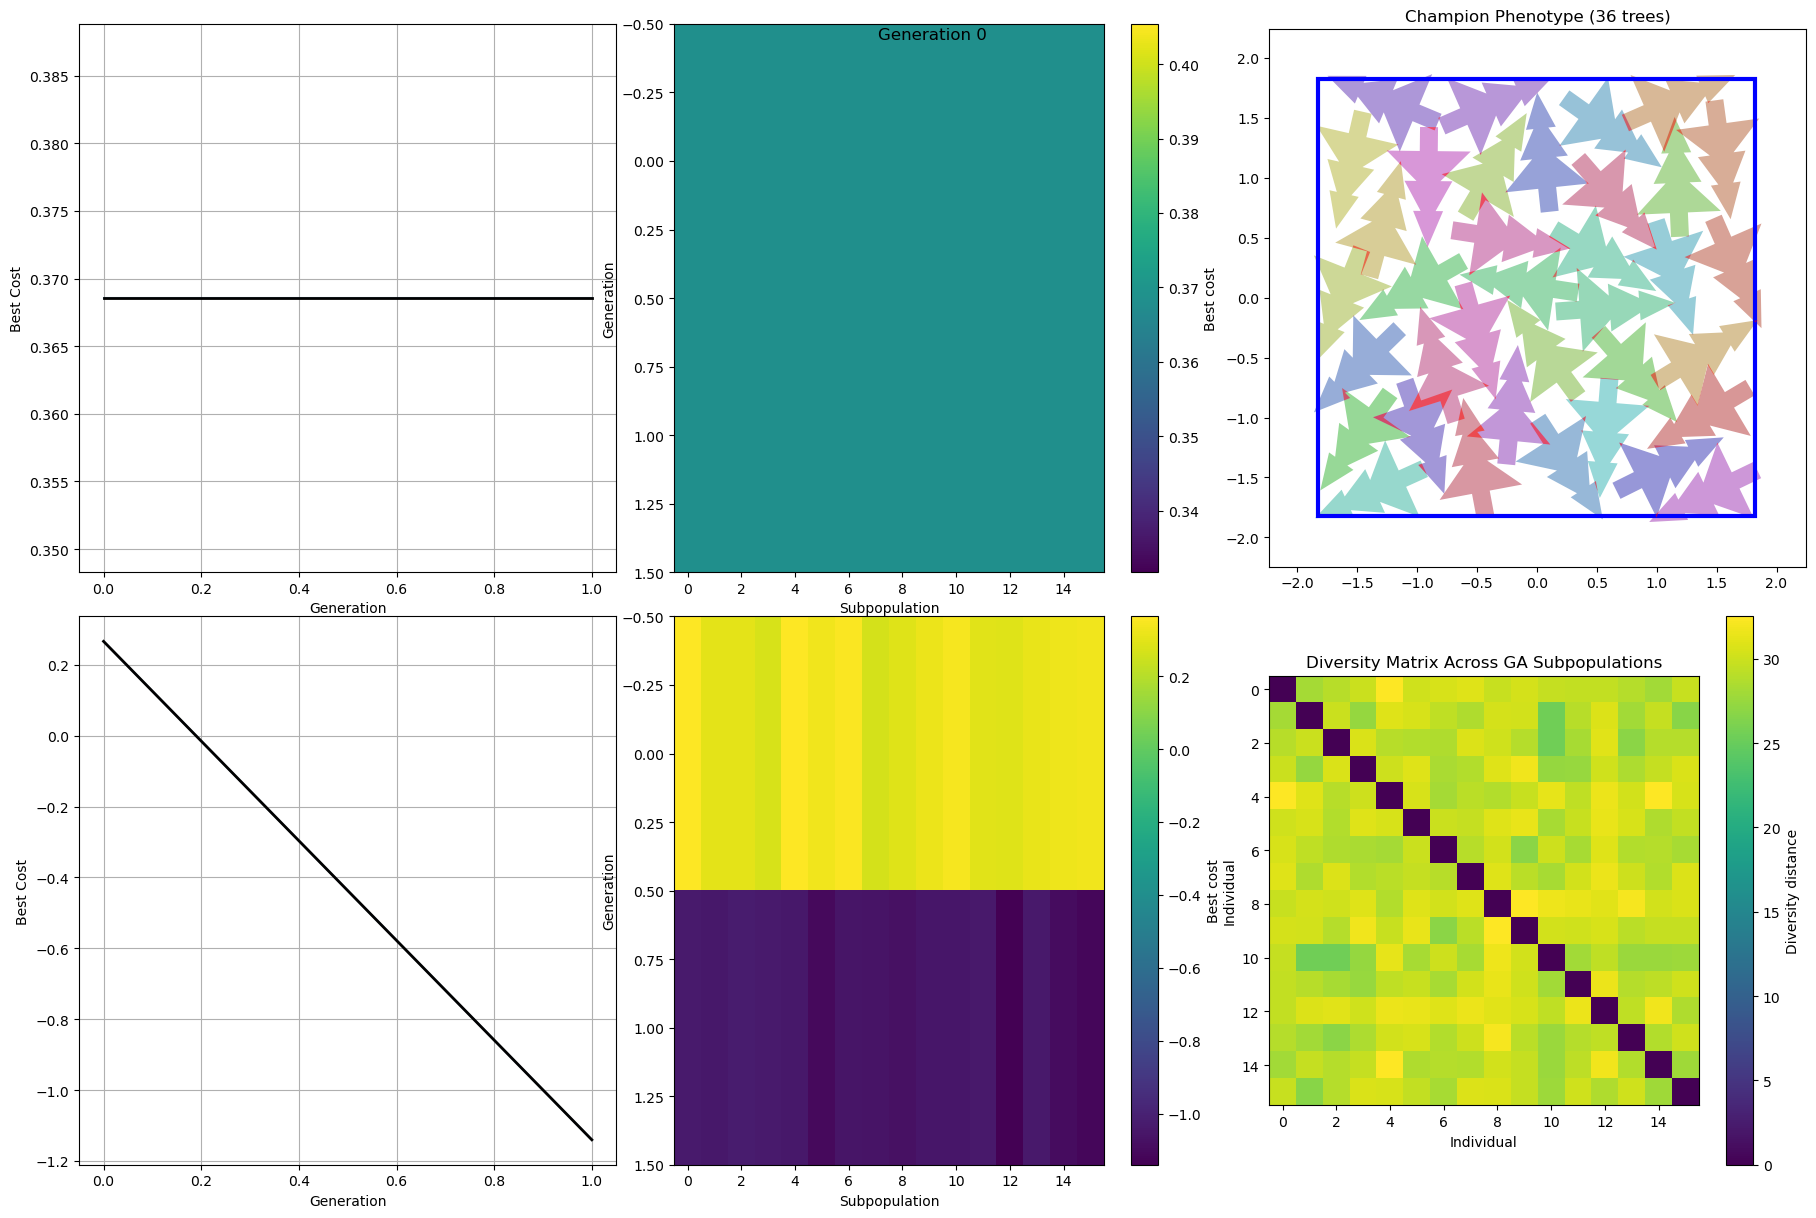

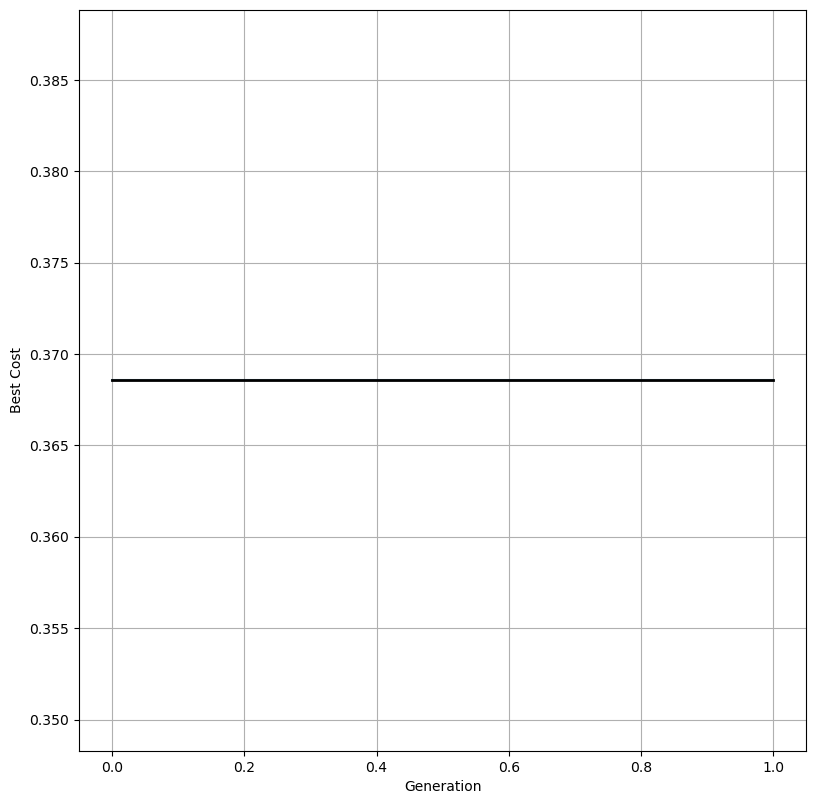

In [ ]:
#%%pyinstrument
#kgs.profiling=True
# %matplotlib widget
import pack_ga3 as pack_ga2
import pack_runner
importlib.reload(pack_ga2)
fastMode = False
kgs.debugging_mode = 2 if fastMode else 1

tmp = pack_ga2.GA()

# runner = pack_ga2.Orchestrator(n_generations=3 if not fastMode else 50)
# runner.ga = pack_ga2.GAMultiRing(N=16 if not fastMode else 4)
# runner.ga.diversity_reset_threshold = 5./40
# runner.ga.mate_distance=6

# ga_base = pack_ga2.GASinglePopulationOld(N_trees_to_do=40)
# #ga_base.population_size = 250
# #ga_base.prob_mate_own = 0.25
# value = 0.125
# ga_base.population_size = int(ga_base.population_size * value)
# ga_base.selection_size = [int( (s-1) * value)+1 for s in ga_base.selection_size]
# seen = set()
# unique_selection = []
# for s in ga_base.selection_size:
#     while s in seen:
#         s += 1
#     seen.add(s)
#     unique_selection.append(s)
# ga_base.selection_size = unique_selection
# ga_base.selection_size = ga_base.selection_size[:-6]
# print(ga_base.selection_size)
# ga_base.do_legalize = False
# ga_base.reset_check_generations = 50 if not fastMode else 3
# ga_base.reset_check_threshold = 0.5 if not fastMode else 0.9
# ga_base.freeze_duration = 100 if not fastMode else 3
# #ga_base.move.moves[-1][2] *= 2
# ga_base.prob_mate_own = 0.7
# ga_base.reduce_h_threshold = 1e-5/40
# ga_base.always_allow_mate_with_better = False
# ga_base.fixed_h = -1.

# runner.ga.ga_base = ga_base
# runner.ga.do_legalize = False
# runner.ga.allow_reset_ratio = 0.5 if not fastMode else 0.
# runner.ga.make_own_fig = (2,3)
# runner.ga.make_own_fig_size = (18,12)
# runner.ga.best_costs_per_generation_ax = ((0,False,(0,0)) ,(1,True,(1,0)))
# runner.ga.plot_subpopulation_costs_per_generation_ax = ( (0,False,(0,1)) ,(1,True,(1,1)))
# runner.ga.champion_phenotype_ax = (0,2)
# runner.ga.plot_diversity_ax = (1,2)
# runner.diagnostic_plot = False
# runner.seed = 0

runner_one_nTree = pack_ga2.baseline()
runner = copy.deepcopy(runner_one_nTree)

ga_list = []
for N_tree in [36]:
    ga_list.append( copy.deepcopy(runner_one_nTree.ga) )
    ga_list[-1].ga_base.N_trees_to_do = N_tree
runner.ga = pack_ga2.GAMulti(single_champion=False)
runner.ga.ga_list = ga_list
runner.ga.make_own_fig = (1,1)
runner.ga.make_own_fig_size = (8,8)
runner.ga.best_costs_per_generation_ax = ((0,False,(0,0)),)
runner.diagnostic_plot = True
runner.plot_every = 3
runner.n_generations = 70 if not fastMode else 3

runner.seed=84
runner.run()

In [ ]:
[x.fitness[0] for x in rr.ga.champions]
rr.ga.ga_list[0].champions

[Population(comment='', genotype=SolutionCollectionSquare(comment='', xyt=array([[[-0.00339492, -0.00339177, -0.7855353 ]]], dtype=float32), h=array([[0.8121147, 0.       , 0.       ]], dtype=float32), use_fixed_h=True, periodic=False), phenotype=SolutionCollectionSquare(comment='', xyt=array([[[-0.00333824, -0.00334019, -0.7853877 ]]], dtype=float32), h=array([[0.8121147, 0.       , 0.       ]], dtype=float32), use_fixed_h=True, periodic=False), fitness=array([[6.5953028e-01, 4.0494172e-07]], dtype=float32), parent_fitness=array([[6.5953028e-01, 4.0500342e-07]], dtype=float32))]

In [ ]:
kgs.dill_save(kgs.temp_dir + 'runner_multi_tree_1to10.pickle', runner)

In [ ]:
rr = kgs.dill_load(kgs.temp_dir + 'runner_multi_tree_1to10.pickle')

N=1 best score: [6.5953028e-01 4.0494172e-07]


1
N=2 best score: [4.4976482e-01 5.4964613e-07]
1
N=3 best score: [4.3353418e-01 1.2509753e-06]
1
N=4 best score: [4.1552681e-01 1.8638094e-06]
1
N=5 best score: [4.1583356e-01 1.6230008e-06]
1
N=6 best score: [3.9878562e-01 2.0132843e-06]
1
N=7 best score: [3.9907715e-01 2.6578523e-06]
1
N=8 best score: [3.8452464e-01 3.1982481e-06]
1
N=9 best score: [3.8212833e-01 2.3559619e-06]
1
N=10 best score: [3.7591243e-01 3.2347239e-06]
1


<Figure size 640x480 with 0 Axes>

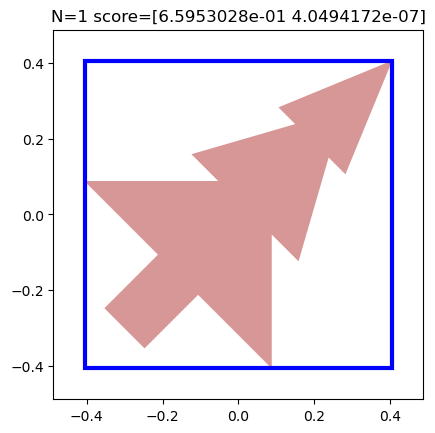

<Figure size 640x480 with 0 Axes>

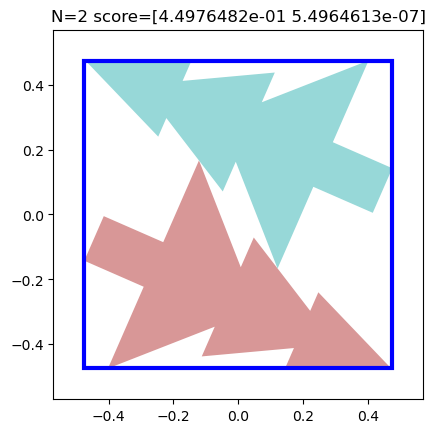

<Figure size 640x480 with 0 Axes>

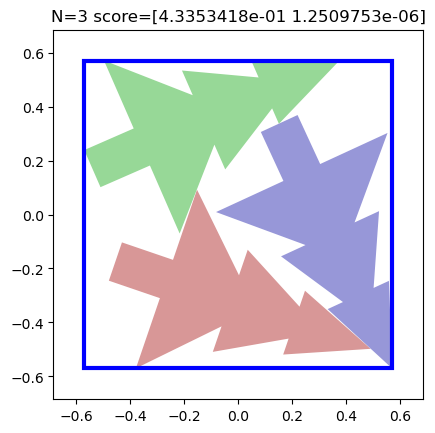

<Figure size 640x480 with 0 Axes>

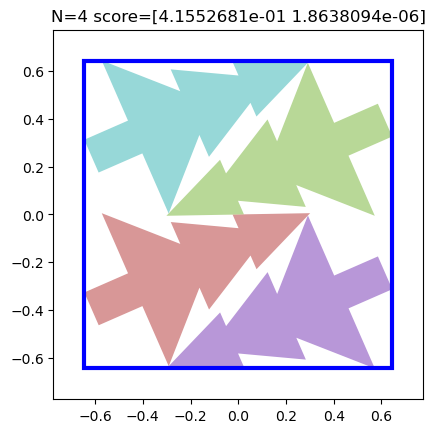

<Figure size 640x480 with 0 Axes>

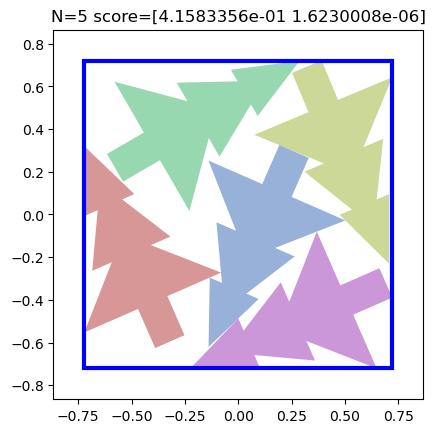

<Figure size 640x480 with 0 Axes>

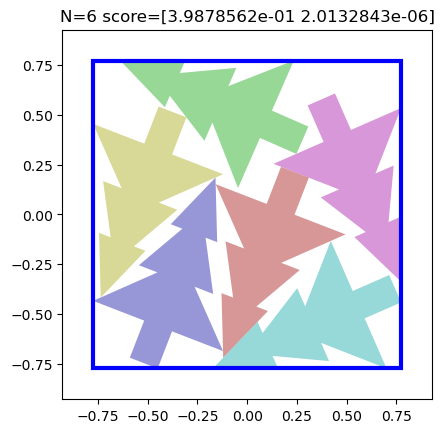

<Figure size 640x480 with 0 Axes>

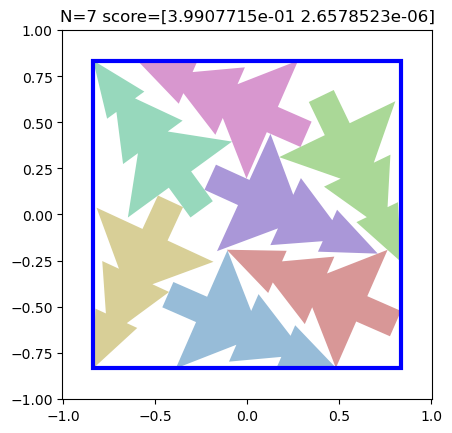

<Figure size 640x480 with 0 Axes>

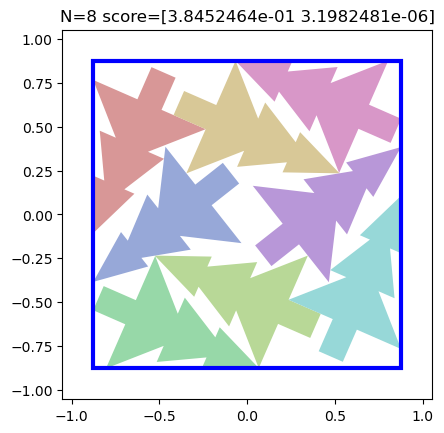

<Figure size 640x480 with 0 Axes>

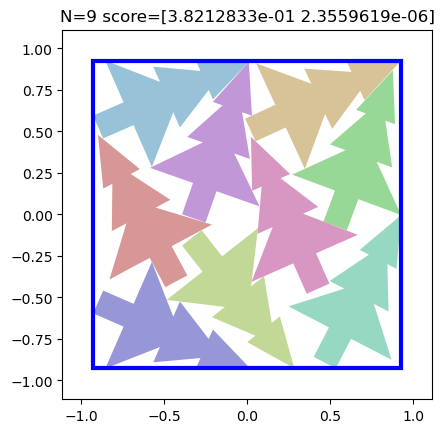

<Figure size 640x480 with 0 Axes>

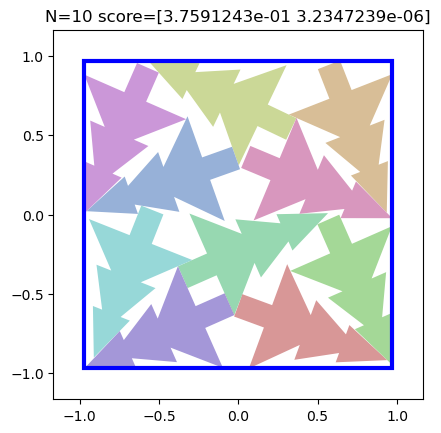

In [ ]:
import pack_vis_sol
#rr.ga.diversity_reset_check_frequency = 1
#for ga in rr.ga.ga_list:
#    ga.diversity_reset_check_frequency = 1
#rr.ga.score(register_best=True) # remove duplicates
for ga in rr.ga.ga_list:
    best_score = ga.champions[-1].fitness[0]
    print(f"N={ga.ga_base.N_trees_to_do} best score: {best_score}")
    ga._fig = None
    ga._ax = None
    #ga.diagnostic_plots(-1,None)
    res = []
    for ga2 in ga.ga_list:        
        if ga2.champions[-1].fitness[0][0] == best_score[0]:
            plt.figure()
            pack_vis_sol.pack_vis_sol(ga2.champions[-1].phenotype)
            plt.title(f"N={ga.ga_base.N_trees_to_do} score={best_score}")
            res.append(ga2.champions[-1].phenotype)
            print(ga2.champions[-1].phenotype.N_solutions)

In [ ]:
# importlib.reload(kgs)
# rrr=copy.deepcopy(res[0])
# rrr.merge(res[1])
# div_matrix = kgs.compute_genetic_diversity_matrix(rrr.xyt, rrr.xyt)
# div_matrix

In [ ]:
for ga in rr.ga.ga_list:
    ga.do_legalize = True
rr.ga.finalize()

Before optimization:  0.006595892831683159 5.899909751860832e-07 0.8121147


/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


After optimization:  0.006471427623182535 4.655988232116215e-05 0.8015527
After optimization:  0.0065297395922243595 1.1798237210314255e-05 0.8073377
After optimization:  0.006568066775798798 2.9875254767830484e-06 0.8102518
After optimization:  0.00658961059525609 7.556033665423456e-07 0.8117176
After optimization:  0.006601334549486637 1.8103983734363283e-07 0.81247485
After optimization:  0.006607001181691885 4.6826649224840367e-08 0.81283176
After optimization:  0.006609933916479349 1.2416841776996534e-08 0.8130142
After optimization:  0.006611212156713009 3.9962788633829405e-09 0.81309336
After optimization:  0.006611368153244257 3.3379681241285653e-09 0.813103
After optimization:  0.0066117942333221436 1.7884014269498039e-09 0.8131293
After optimization:  0.00661234837025404 4.956115517984472e-10 0.81316346
After optimization:  0.00661273580044508 6.814904196517091e-11 0.8131873
Score of generated dataframe: 0.6612518605436782
Before optimization:  0.008995845913887024 5.49640503

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


After optimization:  0.0088756512850523 4.334863115218468e-05 0.9398033
After optimization:  0.00892892200499773 1.2330181561992504e-05 0.94427705
After optimization:  0.008969459682703018 3.1023516839923104e-06 0.9469085
After optimization:  0.008991973474621773 7.8551101978519e-07 0.94821876
After optimization:  0.009003877639770508 2.001240630988832e-07 0.9488771
After optimization:  0.009010152891278267 4.920126173146855e-08 0.94921565
After optimization:  0.009013215079903603 1.3782563534903147e-08 0.9493788
After optimization:  0.009014821611344814 3.439627249690602e-09 0.949464
After optimization:  0.009015686810016632 7.434143856066555e-10 0.9495097
After optimization:  0.009015973657369614 2.8677291097345403e-10 0.9495248
After optimization:  0.009016192518174648 7.51669004817046e-11 0.9495363
Score of generated dataframe: 0.4508074751040004
Before optimization:  0.013007456436753273 1.431233044968394e-06 1.1404396


/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


After optimization:  0.012864419259130955 4.596142753143795e-05 1.1321863
After optimization:  0.012922609224915504 1.713123310764786e-05 1.1360228
After optimization:  0.012978059239685535 4.353645636001602e-06 1.1390218
After optimization:  0.013009575195610523 1.086829911400855e-06 1.1405476
After optimization:  0.013022556900978088 4.0226285591415945e-07 1.1411465
After optimization:  0.013034612871706486 6.829694143561937e-08 1.1416893
After optimization:  0.013038919307291508 1.7063930712879483e-08 1.1418802
After optimization:  0.013040794990956783 5.729109631147367e-09 1.1419628
After optimization:  0.013041971251368523 1.5806114195271448e-09 1.1420145
After optimization:  0.013042430393397808 6.43345154927033e-10 1.1420346
After optimization:  0.013042834587395191 1.6499601684927256e-10 1.1420523
After optimization:  0.013043093495070934 2.6535440511565866e-11 1.1420636
Score of generated dataframe: 0.434763935522452
Before optimization:  0.016622936353087425 1.863629108811437

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


After optimization:  0.016485590487718582 5.861855606781319e-05 1.2816775
After optimization:  0.016560057178139687 1.4642865608038846e-05 1.2862898
After optimization:  0.016607504338026047 3.684793227876071e-06 1.2885581
After optimization:  0.01663409173488617 9.353173027193407e-07 1.289696
After optimization:  0.016648124903440475 2.4284744881697407e-07 1.2902668
After optimization:  0.016655752435326576 5.693475202406262e-08 1.2905695
After optimization:  0.016659386456012726 1.4288689342834004e-08 1.2907119
After optimization:  0.0166609063744545 5.320888618598474e-09 1.2907711
After optimization:  0.016661949455738068 1.6379492207008184e-09 1.2908117
After optimization:  0.016662580892443657 2.628327000486763e-10 1.2908362
After optimization:  0.016662845388054848 5.946697301251191e-11 1.2908465
Score of generated dataframe: 0.4165711151833263
Before optimization:  0.020793367177248 1.6892125813683379e-06 1.441932


/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


After optimization:  0.020524971187114716 0.00010595280036795884 1.4289513
After optimization:  0.020657265558838844 2.658445737324655e-05 1.4363384
After optimization:  0.020743368193507195 6.741228389728349e-06 1.4400218
After optimization:  0.02079262211918831 1.659431291045621e-06 1.4419072
After optimization:  0.02081751823425293 4.4345767946651904e-07 1.4428123
After optimization:  0.020831074565649033 1.1122067888891252e-07 1.4432936
After optimization:  0.020838068798184395 2.7942396840785477e-08 1.4435388
After optimization:  0.020840944722294807 1.1080046213862715e-08 1.4436389
After optimization:  0.020843051373958588 2.5703372763530297e-09 1.4437122
After optimization:  0.0208436269313097 1.3628644879304375e-09 1.4437323
After optimization:  0.02084432542324066 3.8555075798640814e-10 1.4437565
After optimization:  0.020844632759690285 1.5383011531255875e-10 1.4437671
After optimization:  0.02084503136575222 1.0055956067844818e-11 1.4437809
Score of generated dataframe: 0.41

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


After optimization:  0.023731248453259468 8.195701229851693e-05 1.5378326
After optimization:  0.023833300918340683 2.0742512788274325e-05 1.5431318
After optimization:  0.023897061124444008 5.760696694778744e-06 1.5456811
After optimization:  0.023938767611980438 1.2806083304894855e-06 1.5471745
After optimization:  0.023958323523402214 3.295679107395699e-07 1.547837
After optimization:  0.02396845817565918 8.092624170785712e-08 1.5481724
After optimization:  0.023973388597369194 2.2834599988641457e-08 1.5483335
After optimization:  0.02397591806948185 7.626223208490046e-09 1.5484157
After optimization:  0.02397749572992325 1.9617880653299835e-09 1.5484668
After optimization:  0.023978153243660927 8.120737970962466e-10 1.5484881
After optimization:  0.0239787045866251 1.8732772277818555e-10 1.5485059
After optimization:  0.023979011923074722 2.226979711750232e-11 1.5485158
Score of generated dataframe: 0.39964761267854976
Before optimization:  0.027938097715377808 2.6991169761458877e-

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


After optimization:  0.027773229405283928 7.20674725016579e-05 1.6643666
After optimization:  0.027862973511219025 1.8584136341814883e-05 1.6686639
After optimization:  0.027924589812755585 4.5140041038393974e-06 1.6709301
After optimization:  0.027957281097769737 1.1731888207577867e-06 1.672008
After optimization:  0.027975264936685562 2.9301074278009764e-07 1.672572
After optimization:  0.02798433229327202 7.502130472403223e-08 1.6728497
After optimization:  0.027989037334918976 1.9770979520217224e-08 1.6729919
After optimization:  0.027991175651550293 7.134614676829187e-09 1.6730561
After optimization:  0.027992863208055496 1.6845731476422543e-09 1.6731068
After optimization:  0.027993563562631607 4.988752189127865e-10 1.6731278
After optimization:  0.027993978932499886 1.3182765989938616e-10 1.6731402
After optimization:  0.027994191274046898 3.6207925546705155e-11 1.6731465
Score of generated dataframe: 0.39991514052540855
Before optimization:  0.030765170231461525 3.1982190193957

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


After optimization:  0.03054499812424183 9.005154424812645e-05 1.7451346
After optimization:  0.030654177069664 2.4743541871430352e-05 1.7501267
After optimization:  0.03073405660688877 6.787006896047387e-06 1.7529196
After optimization:  0.03078269585967064 1.7110605767811649e-06 1.754451
After optimization:  0.030808983370661736 4.2126484345317294e-07 1.7552369
After optimization:  0.03082161769270897 1.1586737969082606e-07 1.7556053
After optimization:  0.030829014256596565 2.7406489522263655e-08 1.7558186
After optimization:  0.0308314710855484 1.307316654930446e-08 1.7558889
After optimization:  0.030834000557661057 3.1700959635116988e-09 1.7559612
After optimization:  0.030834896489977837 1.0493699242886123e-09 1.7559868
After optimization:  0.030835377052426338 4.4381076591548663e-10 1.7560005
After optimization:  0.030835691839456558 2.0045898274645424e-10 1.7560095
After optimization:  0.030836088582873344 8.169021015191902e-12 1.7560208
Score of generated dataframe: 0.3854474

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


After optimization:  0.03403310850262642 0.00013438306632451713 1.8411607
After optimization:  0.03419565409421921 3.76827156287618e-05 1.8481876
After optimization:  0.0343150794506073 1.0189393833570648e-05 1.852158
After optimization:  0.034388430416584015 2.6826128305401653e-06 1.8543394
After optimization:  0.034421760588884354 9.60151282924926e-07 1.8552843
After optimization:  0.03445024788379669 1.8876939122947078e-07 1.8560728
After optimization:  0.03446148708462715 5.2615860113292e-08 1.8563792
After optimization:  0.03446727991104126 1.725281073561291e-08 1.856536
After optimization:  0.03447010740637779 6.7414522852971e-09 1.8566126
After optimization:  0.03447262570261955 1.707366803493926e-09 1.8566805
After optimization:  0.03447338938713074 7.120536382743126e-10 1.8567011
After optimization:  0.034474000334739685 2.928958187098374e-10 1.8567176
After optimization:  0.034474682062864304 2.299654910942195e-11 1.856736
Score of generated dataframe: 0.3830482089206385
Befo

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


After optimization:  0.03735291585326195 8.724301005713642e-05 1.930432
After optimization:  0.03745526075363159 3.0303777748486027e-05 1.934553
After optimization:  0.03752057999372482 1.347451689071022e-05 1.9366752
After optimization:  0.03760981559753418 1.8072003058478003e-06 1.9392785
After optimization:  0.037637222558259964 4.99932355069177e-07 1.9400185
After optimization:  0.037652257829904556 1.3279979782510054e-07 1.9404155
After optimization:  0.03765913099050522 4.669518816058371e-08 1.9405949
After optimization:  0.037662725895643234 2.5168064965441772e-08 1.940688
After optimization:  0.03766774758696556 3.145725457898152e-09 1.9408181
After optimization:  0.037668246775865555 2.2667439036894166e-09 1.940831
After optimization:  0.03766947612166405 6.973888133643413e-10 1.9408627
After optimization:  0.03766992315649986 3.5373526330317873e-10 1.9408741
After optimization:  0.037670351564884186 1.3545881083487643e-10 1.9408852
After optimization:  0.03767083212733269 7.5

In [ ]:
import pack_io
sol_list = [ga.champions[-1].phenotype for ga in rr.ga.ga_list]
df = pack_io.solution_list_to_dataframe(sol_list)

Score of generated dataframe: 4.324963356794334


In [ ]:
kgs.dill_save(kgs.code_dir + f'../res/ga_{np.min(N_trees_list)}_to_{np.max(N_trees_list)}.pickle', sol_list)